### OCR 만들기 (text detection + recognition)
1. MJ 데이터셋을 불러와서 CRNN recognizer 학습 -> 모델의 가중치 저장
2. keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만듦
3. detector로 sample 이미지 내 텍스트 찾음 -> 1번에서 만든 모델로 단어 추론

In [1]:
# 라이브러리
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

import PIL
from PIL import Image, ImageDraw
import cv2
import keras_ocr
from keras_ocr.detection import Detector

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from IPython.display import display

2024-07-09 08:30:50.384587: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 08:30:53.622969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 08:30:54.866912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 08:30:54.874500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 08:30:56.785262: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# 상수 선언

# 하이퍼 파라미터
BATCH_SIZE = 128

# 데이터 경로
HOME_DIR = './data/'
TRAIN_DATA_PATH = HOME_DIR+'train/'
VALID_DATA_PATH = HOME_DIR+'valid/'
TEST_DATA_PATH = HOME_DIR+'test/'

# 디텍터
detector = Detector()

# 사용할 문자 정의 
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

print(TRAIN_DATA_PATH)


Looking for /root/.keras-ocr/craft_mlt_25k.h5


2024-07-09 08:31:55.319751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 08:31:55.376338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 08:31:55.376366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 08:31:55.378639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 08:31:55.378674: I external/local_xla/xla/stream_executor

./data/train/


### 1. MJ 데이터셋을 불러와서 CRNN recognizer 학습 -> 모델의 가중치 저장

In [3]:
# 모델 학습용 MJSynth데이터셋 클래스를 구현
# TensorFlow/Keras의 Sequence 클래스를 상속받아 데이터셋을 배치 단위로 불러오고 전처리하는 역할
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32), # (width, height)
                 max_text_len=22, # 필터링을 위한 최대 글자 수
                 is_train=False,
                 character='' 
                 ) :
        
        self.label_converter = label_converter  # 레이블을 인코딩/디코딩하는 변환기 설정
        self.batch_size = batch_size  # 배치 크기 설정
        self.img_size = img_size  # 이미지 크기 설정
        self.max_text_len = max_text_len  # 최대 텍스트 길이 설정
        self.character = character  # 사용할 문자 집합 설정
        self.is_train = is_train  # 학습 모드 여부 설정
        self.divide_length = 100  # 나눌 길이 설정

        # LMDB 데이터 열기
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        # LMDB 데이터 접근 
        # 데이터 수 파악 (num-samples는 미리 LMDB에 저장해 둔 전체 데이터의 수)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    # divide_length를 사용함으로써, __len__ 메서드는 전체 배치를 divide_length로 나누어 보다 작은 덩어리로 분할
    # 메모리 사용량을 줄이기 위함
    def __len__(self):
        # 데이터셋의 길이 반환
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    # __getitem__에서 사용됨 
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            # 라벨 가져오기
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            
            # 이미지 가져오기
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            # 이미지 버퍼를 읽어서 이미지 객체로 변환
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')  # 이미지를 RGB로 변환
            except IOError:
                img = Image.new('RGB', self.img_size)  # 이미지 읽기 실패 시 빈 이미지 생성
                label = '-'
            
            width, height = img.size  # 이미지의 가로, 세로 크기 가져오기
            
            target_width = min(int(width * self.img_size[1] / height), self.img_size[0])  # 목표 너비 계산
            target_img_size = (target_width, self.img_size[1])  # 목표 이미지 크기 설정
            img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)  # 이미지를 목표 크기로 조정하고, 배열 형태로 변환
            
            # 라벨을 약간 더 다듬습니다
            label = label.upper()  # 라벨을 대문자로 변환
            out_of_char = f'[^{self.character}]'  # 사용할 문자 집합 설정
            label = re.sub(out_of_char, '', label)  # 사용할 문자 집합 외의 문자 제거
            label = label[:self.max_text_len]  # 최대 텍스트 길이로 자르기

        return (img, label)  # 이미지와 라벨 반환
    
    # __getitem__은 약속되어있는 메서드입니다
    #   __getitem__ 메서드는 Python에서 객체를 인덱싱할 때 호출됩니다. 
    #   MJDatasetSequence 클래스에서 __getitem__은 특정 인덱스에 해당하는 배치를 반환하는 역할을 합니다. 
    #   주로 Keras 모델의 fit 메서드를 호출할 때, 각 배치를 가져오기 위해 내부적으로 사용
    # 이 부분을 작성하면 slice할 수 있습니다
    # 사용 예시 
    ## 첫 번째 배치 가져오기
    ## inputs, outputs = dataset[0]
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    # 
    # Keras 모델의 fit 메서드를 호출할 때, Sequence 객체를 데이터 제너레이터로 사용합니다. 
    # 이때 Keras는 내부적으로 __len__ 메서드를 호출하여 에폭당 배치 수를 계산하고, 각 배치를 가져오기 위해 __getitem__ 메서드를 호출하면서 idx 값을 전달
    # idx = 배치의 순서임 
    def __getitem__(self, idx):
        # 1.idx에 해당하는 index_list만큼 데이터를 불러, todo 왜 idx 2개씩 작업하는지 이해가 안됨
        batch_indicies = self.index_list[
            idx * self.batch_size:
            (idx + 1) * self.batch_size
        ]
        
        # 빈 이미지와 라벨 배열 생성
        # *는 Python의 unpacking 연산자입니다. 이 연산자는 튜플이나 리스트의 요소를 개별 변수로 풀어주는 역할
        input_images = np.zeros([self.batch_size, *self.img_size, 3]) # (B, W, H, C)
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.image와 label을 불러오고 
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)  # 이미지와 라벨 가져오기
            encoded_label = self.label_converter.encode(label)  # 라벨 인코딩
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i, :width, :, :] = img  # 이미지를 입력 배열에 저장 
            labels[i, 0:len(encoded_label)] = encoded_label  # 인코딩된 라벨을 라벨 배열에 저장
            label_length[i] = len(encoded_label)  # 라벨 길이 저장
        
        # 3.사용하기 좋은 inputs과 outputs형태로 반환합니다
        inputs = {
            'input_image': input_images,  # 입력 이미지
            'label': labels,  # 인코딩된 라벨
            'input_length': input_length,  # 입력 길이
            'label_length': label_length,  # 라벨 길이
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}  # CTC 손실을 위한 출력

        return inputs, outputs  # 입력과 출력 반환

In [4]:
# Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있음
# 모델이 학습할 수 있는 형태로 변경
# 각 문자를 class로 생각하고, 
# 이를 step에 따른 class index로 변환해서 encode??

class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character # "-"(블랭크 문자)를 포함하여 문자 집합을 확장
         # 각 문자를 고유한 인덱스로 매핑하는 딕셔너리
         # self.label_map["A"] = 1, self.label_map["B"] = 2와 같은 방식, "-"는 0으로 매핑
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             # 연속된 같은 문자 사이에 블랭크 문자(인덱스 0)를 삽입하여 CTC 손실에서 같은 문자가 연속으로 나올 때 구분할 수 있도록 합니다.
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [5]:
# CTC loss를 계산하기 위한 Lambda 함수
# 이 함수는 모델의 출력과 실제 라벨 간의 손실을 계산하여 모델이 더 정확하게 학습할 수 있도록 합니다.

# 입력 인자
#   labels: 실제 라벨입니다. 인코딩된 형태의 텍스트 라벨입니다.
#   y_pred: 모델의 출력 예측값입니다. Softmax를 거친 후의 확률 값들이 포함되어 있습니다.
#   label_length: 각 라벨의 길이입니다.
#   input_length: 모델의 입력 길이입니다. 보통 입력 시퀀스의 길이를 나타냅니다.

# todo 왜 2개를 잘라내는지 이해가 안됨 - CTC Loss를 계산할 때, 모델의 출력과 라벨의 길이가 달라도 사용할 수 있도록 blank를 포함하여 계산하더라도 1개만 잘라내면 되는데??
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :] 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [6]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    # CTC 블랭크 토큰, ? 문자를 추가한 것을 고려, 위와 마찬가지로 2개 잘라내는 이유가 이해 안됨 . todo
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # CNN부분 
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input) # (100,32,64)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv) # (50,16,64)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv) # (50,16,128)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv) # (50,2,512)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)      # (50,1,512)
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv) # (49,1,512)
    # RNN부분
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)
    # CTC 손실 함수에 필요한 입력 생성 
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    # CTC 손실 계산
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    # 모델 정의 및 반환
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [7]:
# 사용할 문자를 인코딩함
label_converter = LabelConverter(TARGET_CHARACTERS)
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [8]:
print(train_set[0][0]['input_image'].shape)
print(train_set[0][0].keys())
# print(train_set[0][0]['input_image'].dtype())
# print(train_set[0][0]['label'].dtype())
# print(train_set[0][0]['input_length'].dtype())
# print(train_set[0][0]['label_length'].dtype())

(128, 100, 32, 3)
dict_keys(['input_image', 'label', 'input_length', 'label_length'])


In [9]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = 'model_checkpoint.keras'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False
)

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=50,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
          callbacks=[ckp, earlystop]
)

Epoch 1/50


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data_2:0", shape=(None,), dtype=int64). Expected shape (None, 22), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs={'input_image': 'tf.Tensor(shape=(None, 100, 32, 3), dtype=float64)', 'label': 'tf.Tensor(shape=(None, 22), dtype=int64)', 'input_length': 'tf.Tensor(shape=(None,), dtype=int64)', 'label_length': 'tf.Tensor(shape=(None,), dtype=int64)'}
  • training=True
  • mask={'input_image': 'None', 'label': 'None', 'input_length': 'None', 'label_length': 'None'}

### 2. keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만듦

In [ ]:
def detect_text(img_path):
    # 이미지 읽기
    img_pil = Image.open(img_path).convert("RGB")
    img = np.array(img_pil)
    
    # 배치 크기를 위해 차원 확장 및 입력 차원 맞춤 (H, W, C) -> (1, H, W, C)
    # detector.detect()의 입력 차원에 맞추기 위해
    img_expanded = np.expand_dims(img, axis=0) 
    
    # 텍스트 감지
    ocr_result = detector.detect(img_expanded)[0]
    
    # 시각화를 위한 원본 이미지 복사
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)
    
    cropped_imgs = []
    for text_result in ocr_result:
        # 텍스트 영역 시각화
        img_draw.polygon([tuple(point) for point in text_result], outline='red')
        
        # 텍스트 영역 잘라내기
        x_min = int(text_result[:, 0].min()) - 5
        x_max = int(text_result[:, 0].max()) + 5
        y_min = int(text_result[:, 1].min()) - 5
        y_max = int(text_result[:, 1].max()) + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return result_img, cropped_imgs

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


I0000 00:00:1720507950.878739  242679 service.cc:145] XLA service 0xbcb5180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720507950.878777  242679 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-07-09 06:52:31.013759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 06:52:31.276005: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1720507956.853104  242679 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


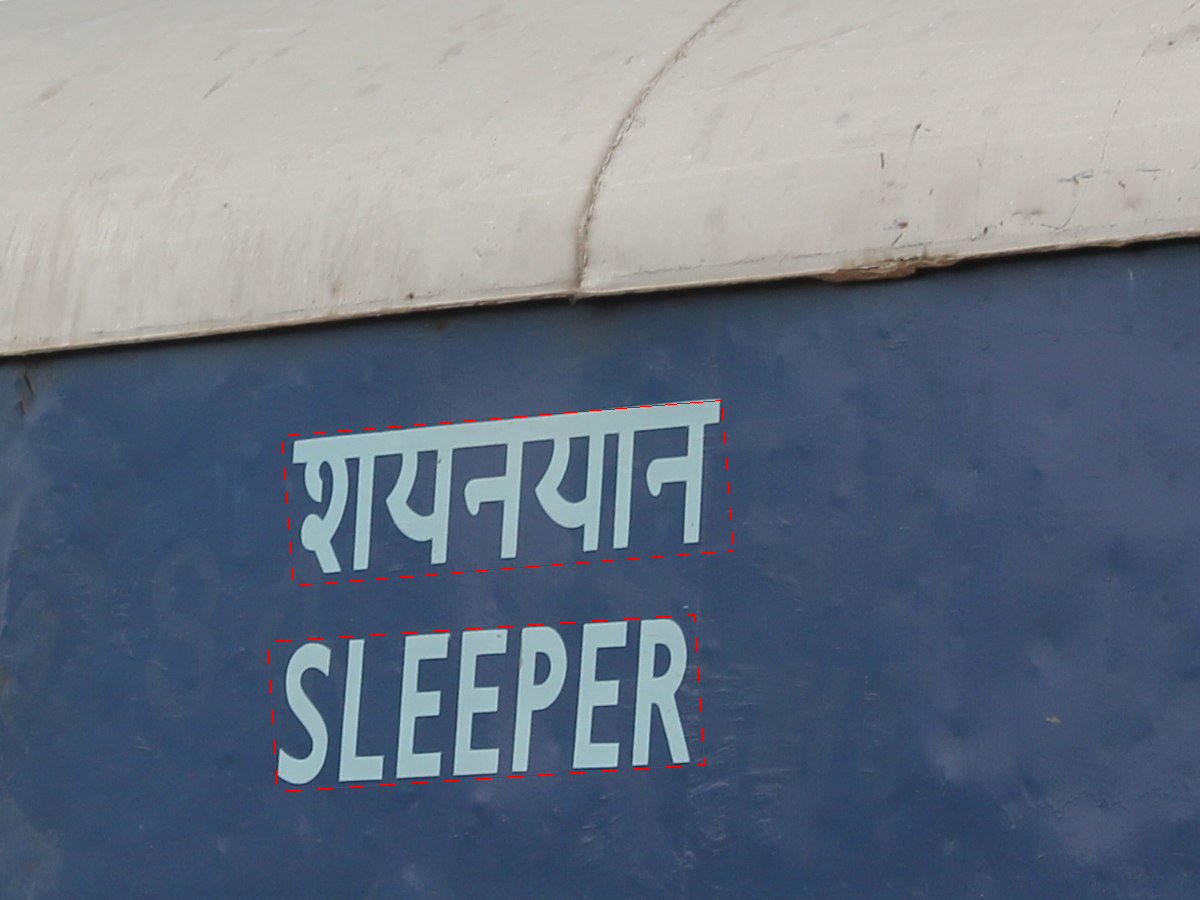

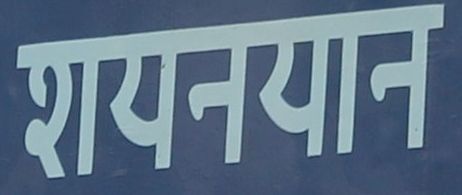

(462, 195)


In [ ]:
# 테스트
SAMPLE_IMG_PATH = './data/sample.jpg'
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)
display(cropped_img[0])
print(cropped_img[0].size)

### 3. MJ test 이미지를 불러옴. 2번에서 만든 detector로 이미지 내 텍스트 찾음 -> 1번에서 만든 모델로 추론

In [ ]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = 'model_checkpoint.keras'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Result: 	 SN9999999999999999999999


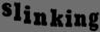

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 999999999999999999999999


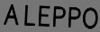

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Result: 	 999999999999999999999999


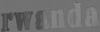

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Result: 	 S99999999999999999999999


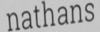

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Result: 	 999999999999999999999999


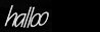

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 999999999999999999999999


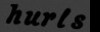

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 MS9999999999999999999999


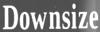

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 999999999999999999999999


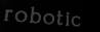

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 S99999999999999999999999


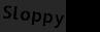

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: 	 P99999999999999999999999


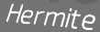

In [ ]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다 -> 어렵다고 하니 넘어가고, 프로젝트 후에 다시 보기
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [ ]:
# TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
def recognize_img(pil_img, input_img_size=(100,32)):
    